In [16]:
import os
import re
import json
import requests
from itertools import islice

import pandas as pd
import xarray as xr
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sqlmodel import SQLModel, Session, create_engine

from matched.db.tables import Rego, Ro, ERA5Derived
from matched.db.utils import read_table, bulk_upsert_records

In [2]:
engine = create_engine(f"sqlite:///../data/matched.db")

In [3]:
data_dir = '../data/rego_generators'

files = os.listdir(data_dir)

annual_files = sorted([f for f in files if f[-7]!='_'])
monthly_files = sorted(list(set(files)-set(annual_files)))

monthly_files

['accredited_stations_2023_01.csv',
 'accredited_stations_2023_02.csv',
 'accredited_stations_2023_03.csv',
 'accredited_stations_2023_04.csv',
 'accredited_stations_2023_05.csv',
 'accredited_stations_2023_06.csv',
 'accredited_stations_2023_07.csv',
 'accredited_stations_2023_08.csv',
 'accredited_stations_2023_09.csv',
 'accredited_stations_2023_10.csv',
 'accredited_stations_2023_11.csv',
 'accredited_stations_2023_12.csv']

In [4]:
bad_dates = {
    '16/12/2009\n\r22/12/2009': '22/12/2009',
    '21/01/2010\n\r26/01/2010': '26/01/2010',
    '22/03/2010\n\r22/03/2010': '22/03/2010',
}

for file in annual_files:
    year = int(file[-8:-4])

    if year in [
        2003,  # 2004, 2005, 2006, 2007, 2008, 20
        2008,  # 2009, 2010
        2009,  # 2008, 2010
        2010,  # 2008, 2009, 2011
        2011,  # 2008, 2010, 2012, 2020
        2012,  # 2008, 2009, 2011
        2013,  # 2008, 2009, 2011, 2012, 2016, 2017
        2014,  # 2008, 2012, 2013, 2015, 2016
        2015,  # 2008, 2009, 2012, 2013, 2014, 2016, 2021
        2016,  # 2008, 2012, 2013, 2014, 2015, 2017
        2017,  # 2008, 2015, 2016, 2018
        2018,  # 2015, 2016, 2017
        2019,  # 2017, 2018, 2021
        2020,  # 2008, 2014, 2015, 2016, 2019
        2021,  # 2008, 2016, 2019, 2020
        2022,  # 2013, 2015, 2016, 2019, 2020
    ]:
        continue

    df = pd.read_csv(f'{data_dir}/{file}')
    df['AccreditationDate'] = pd.to_datetime(df['AccreditationDate'].replace(bad_dates), format='%d/%m/%Y')

    year_counts = df['AccreditationDate'].dt.year.value_counts().sort_index()
    assert year_counts.shape[0] == 1, f'file {file} has more than one year'
    assert year_counts.index[0] == year, f'file {file} has month {year_counts.index[0]}'

In [5]:
for file in monthly_files:
    month = int(file[-6:-4])

    if month in [
        3,  # 2015-07-17
        4,  # 2023-08-16, 2023-03-16
        8,  # 2023-11-28
        9,  # 2023-10-09
        10, # 2023-12-13
        11, # 2024-04-26
    ]:
        continue

    df = pd.read_csv(f'{data_dir}/{file}')
    df['AccreditationDate'] = pd.to_datetime(df['AccreditationDate'], format='%d/%m/%Y')

    year_counts = df['AccreditationDate'].dt.year.value_counts()
    month_counts = df['AccreditationDate'].dt.month.value_counts()
    assert year_counts.shape[0] == 1, f'file {file} has more than one year'
    assert year_counts.index[0] == 2023, f'file {file} has month {year_counts.index[0]}'
    assert month_counts.shape[0] == 1, f'file {file} has more than one month'
    assert month_counts.index[0] == month, f'file {file} has month {month_counts.index[0]}'

In [6]:
df_rego_generators = pd.concat([pd.read_csv(f'{data_dir}/{file}') for file in sorted(files)])

print(df_rego_generators.shape)
df_rego_generators.head()

(131103, 14)


,GeneratorID,StatusName,GeneratorName,SchemeName,Capacity,Country,TechnologyName,OutputType,AccreditationDate,CommissionDate,textbox6,textbox61,FaxNumber,textbox65
0,G02583NWSC,Live,Emly Bank RO,REGO,15000.0,Scotland,Wind,General,01/09/2002,01/09/2002,ECRGEN,RWE Renewables UK Limited\rWindmill Hill Busin...,NaN,Bowbeat Emly Bank\rEngine Road\rGorebridge\rEH...
1,G00189LGWA,Live,Ferry Road,REGO,57.5,Wales,Landfill Gas (REGO code = LG),General,01/04/2002,01/12/1999,Renewable Power Systems,Unit 11\rBedford Business Centre\rMile Road B...,NaN,Ferry Road\rGrangetown\rCardiff\rCF11 0JR\rWales
2,G01335SGEN,Live,Stoke Bardolph STW - Dual Fuel,REGO,3067.0,England,Sewage gas (REGO code = SG),General,01/04/2002,01/05/1999,Severn Trent Water Ltd,Severn Trent Water Ltd\rWanlip STW\rFillingate...,NaN,Stoke Bardolph STW\rStoke Lane\rBurton Joyce\r...
0,G00276HYSC,Live,Achanalt Power Station - A,REGO,3100.0,Scotland,Hydro,General,27/10/2003,01/01/1956,SSE Generation Ltd,Scottish Hydro Electric plc\rInveralmond House...,NaN,Achanalt Power Station\rAchanalt Power Station...
1,G00816HYSC,Live,Acharn Hydro,REGO,380.0,Scotland,Hydro,General,27/10/2003,01/12/1992,Acharn Hydro Ltd,Remony Estate Partnership\rRemony House\rABERF...,NaN,Acharn Hydro\rRemony EstateAcharnAberfeldyPert...


In [7]:
df_rego_generators.dtypes

GeneratorID           object
StatusName            object
GeneratorName         object
SchemeName            object
Capacity             float64
Country               object
TechnologyName        object
OutputType            object
AccreditationDate     object
CommissionDate        object
textbox6              object
textbox61             object
FaxNumber             object
textbox65             object
dtype: object

0.00          0.00
0.01          1.00
0.25          3.09
0.50          3.47
0.75          3.69
0.99       4512.00
1.00    3865000.00
Name: Capacity, dtype: float64


<Axes: xlabel='Capacity', ylabel='Count'>

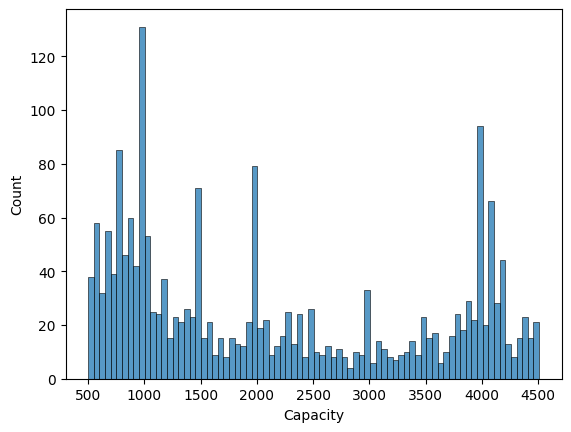

In [8]:
s_quantiles = df_rego_generators['Capacity'].quantile([0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])
print(s_quantiles)

s_filtered_generators = df_rego_generators.loc[(
    (df_rego_generators['Capacity']<s_quantiles.loc[0.99]) & 
    (df_rego_generators['Capacity']>500)
), 'Capacity']

sns.histplot(s_filtered_generators, binwidth=50)

In [9]:
def extract_postcode(address):
    postcode_pattern = re.compile(r'\b[A-Z]{1,2}\d[A-Z\d]? \d[A-Z]{2}\b')
    match = postcode_pattern.search(address)
    return match.group(0) if match else None

s_postcodes = df_rego_generators.set_index('GeneratorID')['textbox65'].dropna().apply(extract_postcode)

s_postcodes

GeneratorID
G02583NWSC    EH23 4AE
G00189LGWA    CF11 0JR
G01335SGEN    NG14 5HL
G00276HYSC    IV23 2QD
G00816HYSC    PH15 2HR
                ...   
G01710NWWA    NP23 5SD
G24237PVEN    PE14 0LX
G24253PVEN    YO42 4PW
G00783MWSC     FK3 8XG
G24228PVEN    PE12 9TF
Name: textbox65, Length: 9727, dtype: object

In [11]:
def chunked_iterable(iterable, size):
    """Helper function to split iterable into chunks of specified size."""
    it = iter(iterable)
    return iter(lambda: tuple(islice(it, size)), ())

def bulk_postcode_lookup(postcodes, filters=None):
    results = []
    url = "https://api.postcodes.io/postcodes"
    headers = {"Content-Type": "application/json"}
    
    for chunk in tqdm(chunked_iterable(postcodes, 100), total=len(postcodes)//100):
        if filters:
            request_url = f"{url}?filter={filters}"
        else:
            request_url = url
        
        response = requests.post(request_url, headers=headers, data=json.dumps({"postcodes": chunk}))
        
        if response.status_code == 200:
            results.extend(response.json().get("result", []))
        else:
            return {"error": f"Request failed with status code {response.status_code}"}
    
    return results

filters = "postcode,longitude,latitude"
result = bulk_postcode_lookup(list(s_postcodes.values), filters)

print(len(result))
result[:5]

98it [00:28,  3.40it/s]                        

9047


[{'query': 'EH23 4AE',
  'result': {'postcode': 'EH23 4AE',
   'longitude': -3.059807,
   'latitude': 55.847396}},
 {'query': 'CF11 0JR',
  'result': {'postcode': 'CF11 0JR',
   'longitude': -3.185708,
   'latitude': 51.457292}},
 {'query': 'NG14 5HL',
  'result': {'postcode': 'NG14 5HL',
   'longitude': -1.055149,
   'latitude': 52.971041}},
 {'query': 'IV23 2QD',
  'result': {'postcode': 'IV23 2QD',
   'longitude': -4.938962,
   'latitude': 57.609723}},
 {'query': 'PH15 2HR',
  'result': {'postcode': 'PH15 2HR',
   'longitude': -4.017407,
   'latitude': 56.570426}}]

<Axes: >

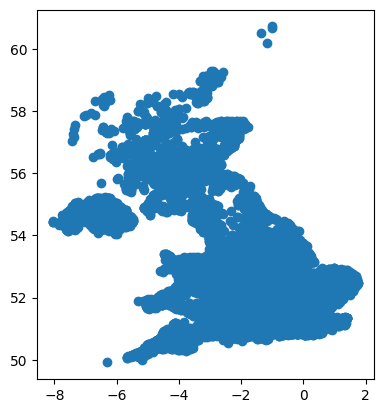

In [12]:
df = pd.DataFrame([item['result'] for item in result if item['result'] is not None])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

gdf.plot()

In [13]:
file_path = '../data/adaptor.mars.internal-1719939154.2515023-12402-17-21cabed0-514d-4aea-b596-2fd3ec3e2e9d.nc'
ds = xr.open_dataset(file_path)

concat_dfs = []

for _, (lat, lon) in tqdm(df[['latitude', 'longitude']].iterrows()):
    concat_dfs.append(
        ds
        .interp(latitude=lat, longitude=lon)
        .to_dataframe()
        .reset_index()
        .set_index('time')
    )

df_generator_weather = pd.concat(concat_dfs)

df_generator_weather

8873it [04:52, 30.30it/s]


,u100,v100,u10,v10,t2m,latitude,longitude
time,,,,,,,
2023-01-01 00:00:00,-6.124319,-3.505972,-3.560769,-2.348238,276.145746,55.847396,-3.059807
2023-01-01 01:00:00,-6.742890,-2.875081,-3.877618,-1.970390,276.423940,55.847396,-3.059807
2023-01-01 02:00:00,-7.046638,-2.222430,-4.302080,-1.537414,276.582922,55.847396,-3.059807
2023-01-01 03:00:00,-6.909157,-2.214752,-4.244857,-1.446608,276.669096,55.847396,-3.059807
2023-01-01 04:00:00,-6.288494,-1.625808,-3.841061,-1.031566,276.455792,55.847396,-3.059807
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,8.408242,8.407823,4.883450,5.434127,280.539006,52.757118,0.193097
2023-12-31 20:00:00,8.962347,7.840876,5.276976,5.170452,280.355277,52.757118,0.193097
2023-12-31 21:00:00,9.418240,7.251688,5.612800,4.835192,280.219222,52.757118,0.193097


In [17]:
with Session(engine) as session:
    SQLModel.metadata.create_all(engine, tables=[ERA5Derived.__table__])
    bulk_upsert_records(session, df_generator_weather, ERA5Derived)